In [33]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify'
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [ ]:
# !pip install wandb -qqq
# import wandb
# wandb.login()

In [34]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time
import math

## Data 

In [35]:
#---# LOAD npy file #---#
Fu_20_normal = np.load('Fu_20_normal.npy')
Fu_21_normal = np.load('Fu_21_normal.npy')
Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
Fu_22_normal = np.load('Fu_22_normal.npy')
Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

# import sys
# np.set_printoptions(threshold=sys.maxsize) # print all

#---# 확인용 #---#
# plt.figure(figsize=(30,5))
# plt.plot(Fu_22_abnormal_10)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class MyDataset(Dataset):
  def __init__(self, data):
    self.data = np.array(self.sliding_window(data, config.window_size, config.stride))
    self.data = self.data.reshape(-1, config.window_size)
    
  def __getitem__(self, index):
    self.x = self.data[index]
    return (index, torch.Tensor(self.x))
      
  def __len__(self):
    return len(self.data)

  #---# Window #---#
  def sliding_window(self, arr, window_size, stride):
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data


def sliding_window(arr, window_size, stride): ######### 중복
    start_pt = 0
    total_data = []
    while(True) :
      if len(arr) < (start_pt + window_size) : break
      data = arr[start_pt:start_pt+window_size]
      start_pt += stride
      total_data.append(data)
    return total_data

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore


def get_anomaly_time(original, prediction) : 
  temp = np.zeros(shape=(len(original),), dtype=np.float32)
  original = original.squeeze(axis = 1)

  for i in range(len(prediction)) :
    if prediction[i] == 0 :
      temp[i*config.stride : (i*config.stride + config.window_size)] = np.nan

    elif prediction[i] == 1 : # anomaly
      temp[i*config.stride : (i*config.stride + config.window_size)] = original[i*config.stride : (i*config.stride + config.window_size)]

  return temp


def drawing(pred, x) :
  #---# Drawing - 22 #---#
  plt.figure(figsize=(30,5))
  plt.plot(x, markersize=1)
  plt.plot(pred, marker='.', markersize=2, color='r', linestyle='None')

  '''
  for i in range(len(pred)):
    if pred[i] == 1:
      # plt.vlines(i * config.window_size, -1, 4, colors="y")
      # plt.vlines((i+1) * config.window_size, -1, 4, colors="y")
      before = i * config.window_size
      after = (i+1) * config.window_size

      r = np.linspace(before, after)
      plt.fill_between(r, -1, 4, color = "yellow", alpha = 0.5)
  '''

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65300)
  # plt.fill_between(a, 0, 2000, color='green', alpha=0.3)
  plt.fill_between(a, -1, 4, color='green', alpha=0.5)
  b = np.linspace(95600, 99300)
  # plt.fill_between(b, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(b, -1, 4, color='green', alpha=0.5)
  c = np.linspace(148400, 152300)
  # plt.fill_between(c, 0, 2000, color='green', alpha=0.5)
  plt.fill_between(c, -1, 4, color='green', alpha=0.5)

  plt.show()
  plt.clf()

def calculate(true_list, pred_list) : 
  pred_list = pred_list.dropna()

  pred_anomaly_set = set(pred_list.index.tolist())
  pred_normal_set = set(range(len(true_list))) - pred_anomaly_set
  true_anomaly_set = set(np.where(np.array(true_list) != 0)[0].tolist())
  true_normal_set = set(np.where(np.array(true_list) == 0)[0].tolist())

  recall = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(true_anomaly_set)
  accuracy = len(pred_anomaly_set.intersection(true_anomaly_set)) / len(pred_anomaly_set.union(true_anomaly_set)) # len(anomaly_set.union(true_set))
  # accuracy = (len(pred_anomaly_set.intersection(true_anomaly_set)) + len(pred_normal_set.intersection(true_normal_set))) / len(true_list) # (빨간 거 맞은거 + 파란거 맞은거) / 전체
  return recall, accuracy

In [38]:
config = easydict.EasyDict({
    "num_epochs" : 2, #500
    "batch_size" : 16, #16 
    "mode" : 'train',
    # "mode" : "test",
    "lr" : 1e-3, 
    "wd" : None,
    "window_size" : 1000,
    "stride" : 250,
    "threshold" : 0.3, # 0.3이나 0.2로 하기
    "seed" : 1004
})
seed_everything(config.seed)
tm = time.localtime(time.time())
string = time.strftime('%Y%m%d_%H%M%S', tm)

# wandb.init(project="Anomaly-Oil", entity="sohyun", name=string, magic=True)

train = pd.DataFrame(Fu_22_normal_10, columns=['Fu'])
train = pd.concat([train, pd.DataFrame(Fu_21_normal_10, columns=['Fu']), pd.DataFrame(Fu_20_normal_10, columns=['Fu'])], axis=0)
test = pd.DataFrame(Fu_22_abnormal_10, columns=['Fu'])
test_len = len(test)
total = pd.DataFrame(pd.concat([train, test], axis=0))

# train_scale = train['Fu'].values
# test_scale = test['Fu'].values
# total_scale = total['Fu'].values

#---# Noramlize #---#
scaler = StandardScaler()
total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist() # total 먼저 해놓고 transform
train_scale = scaler.transform(train); train_scale = pd.DataFrame(train_scale, columns=['Fu'])['Fu'].values.tolist()
test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

# scaler = MinMaxScaler()
# total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist()
# test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

#---# Setting train data #---# 나머지 끊어주어야 함
train_dataset1 = MyDataset(data=train_scale[:len(Fu_22_normal_10)])
train_dataset2 = MyDataset(data=train_scale[len(Fu_22_normal_10):(len(Fu_22_normal_10)+len(Fu_21_normal_10))])
train_dataset3 = MyDataset(data=train_scale[(len(Fu_22_normal_10)+len(Fu_21_normal_10)):])
train_dataset = np.concatenate([train_dataset1.data, train_dataset2.data, train_dataset3.data], axis = 0)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dataset = MyDataset(data=test_scale)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)


# optimizer = torch.optim.Adam(params = model.parameters(), lr = config.lr) # lr = config.lr
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

##########################
#---# true list 만들기 #---#
##########################
true_label = [0 for i in range(len(test_scale))] # test_scale
true_label[62200:65300] = [1 for i in range(62200,65300)]
true_label[95600:99300] = [1 for i in range(95600,99300)]
true_label[148400:152300] = [1 for i in range(148400,152300)]

true_label_sliding = sliding_window(np.array(true_label), config.window_size, config.stride)
true_label_sliding = np.expand_dims(np.array(true_label_sliding), 2) # dimension expansion

In [39]:
!pip install orion-ml -qqq

In [40]:
from pandas.tseries.offsets import Second
from datetime import date, timedelta
from orion import Orion
from datetime import datetime
from mlprimitives import load_primitive

def make_timestamp(date, data_len) :
  # start_date = datetime.strptime('201802210000', '%Y%m%d%H%M')
  start_date = datetime.strptime(date, '%Y%m%d%H%M')
  timestamp = time.mktime(start_date.timetuple())
  dates = []; dates.append(timestamp)

  for i in range(data_len-1) :
    new_start_date = start_date + timedelta(minutes=10)
    timestamp = time.mktime(new_start_date.timetuple())
    dates.append(timestamp)
    start_date = new_start_date
  
  return dates

dates = make_timestamp('201802210000', len(train_scale))
traindata = pd.DataFrame({"timestamp":dates, "value":train_scale})
dates_test = make_timestamp('201802211200', len(test_scale))
testdata = pd.DataFrame({"timestamp":dates_test, "value":test_scale})


In [41]:
###################################
#---# Rolling window sequence #---#
###################################
'''
window_size 
target_size
step_size
target_column
drop_windows
'''
primitive = load_primitive('mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences', 
                           arguments={'window_size':1000, 'target_size':0, 'step_size':250, 'target_column':0, 'drop_windows':False})
traindata = np.array(train_scale).reshape(-1, 1)
index = np.array(range(len(train_scale))).reshape(-1, 1)
X, y, index, target_index = primitive.produce(X=traindata, index=index)

testdata = np.array(test_scale).reshape(-1, 1)
index_test = np.array(range(len(test_scale))).reshape(-1, 1)
X_test, y_test, index_test, target_index_test = primitive.produce(X=testdata, index=index_test)

print(f"X shape = {X.shape}, y shape = {y.shape}, index shape = {index.shape}, target_index shape = {target_index.shape}")

X shape = (2447, 1000, 1), y shape = (2447, 0), index shape = (2447, 1), target_index shape = (2447, 1)


LSTM

In [ ]:
################
#---# LSTM #---#
################
'''
classification
epochs
callbacks
validation_split : default = 0.2
batch_size : default = 64
input_shape : 
dense_units : number of values ahead to predict (target size). default = 1
optimizer : default = keras.optimizers.Adam
loss : default = keras.mean_squared_error
metrics : defualt = ['mse']
return_seqeunces : whether to return the last output in the output sequence or the full sequence. default = False
layers : list of keras layers which are the basic building blocks
verbose : default = False
lstm_1_unit : dimensionality of the output space for the first LSTM layer. default = 80
dropout_1_rate : float(0~1) default = 0.3
lstm_2_unit
dropout_2_rate7
'''
print("============== LSTM ==============")
# kk = np.array(train_scale).reshape(1,-1,1)
primitive = load_primitive('keras.Sequential.LSTMTimeSeriesRegressor',
                           arguments = {"X":X, "y":y, "batch_size":1, "validation_split":0.2, "input_shape":(1000,1)}) #"input_shape":()
# print(primitive.metadata)
primitive.fit()
pred = primitive.produce(X=X_test)
print(pred)


primitive = load_primitive('orion.primitives.timeseries_errors.regression_errors')
errors = primitive.produce(y=X_test, y_hat=pred)
print(f"average error value : {errors.mean()}")


primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies')
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("===error_range===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

============== LSTM ==============


ValueError: ignored

LSTM AE

============== LSTM AE ==============
Train on 1957 samples, validate on 490 samples
Epoch 1/1
932/932 [==============================] - 17s 18ms/step


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


=== error_range ===
 [[141.         153.           1.00459499]
 [249.         260.           1.0917241 ]
 [384.         421.           1.07065969]
 [595.         611.           0.9193199 ]]


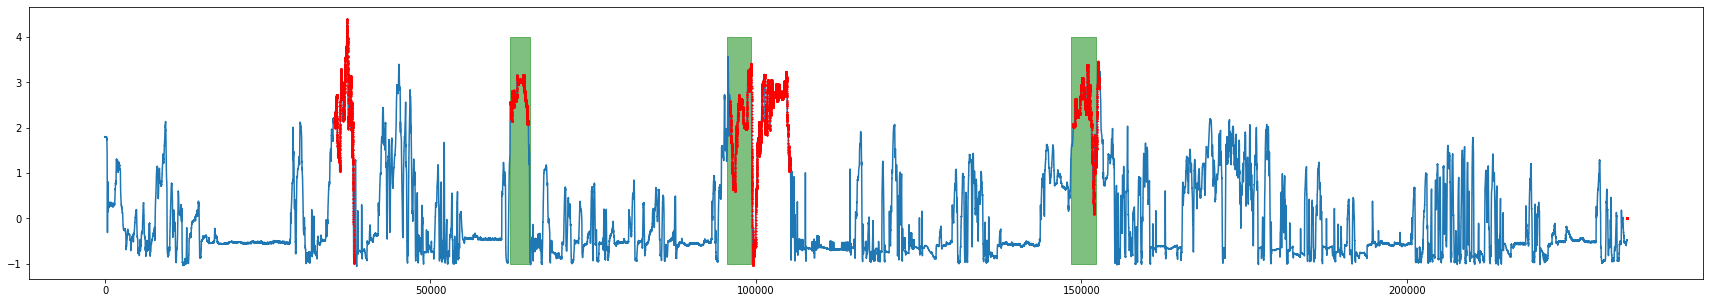

recall : 0.897196261682243, accuracy : 0.47635587753684316


<Figure size 432x288 with 0 Axes>

In [42]:
###################
#---# LSTM AE #---#
###################
print("============== LSTM AE ==============")
primitive = load_primitive('keras.Sequential.LSTMSeq2Seq',
                          arguments = {'X':X, "y":X, "classification":False, 
                                        "epochs":1,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "window_size":1000, "batch_size":8, 
                                        "validation_split":0.2})
primitive.fit()
pred = primitive.produce(X=X_test)
# pred.mean()

primitive = load_primitive('orion.primitives.timeseries_errors.reconstruction_errors')
errors, predictions = primitive.produce(y=X_test, y_hat=pred)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                          arguments = {'anomaly_padding':1})

error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("=== error_range ===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

Dense AE

============== Dense AE ==============
Train on 1957 samples, validate on 490 samples
Epoch 1/2000
1957/1957 [==============================] - 2s 955us/step - loss: 0.7354 - mse: 0.7354 - val_loss: 0.4704 - val_mse: 0.4704
Epoch 2/2000
1957/1957 [==============================] - 1s 310us/step - loss: 0.5725 - mse: 0.5725 - val_loss: 0.3543 - val_mse: 0.3543
Epoch 3/2000
1957/1957 [==============================] - 1s 313us/step - loss: 0.4758 - mse: 0.4758 - val_loss: 0.2957 - val_mse: 0.2957
Epoch 4/2000
1957/1957 [==============================] - 1s 316us/step - loss: 0.4193 - mse: 0.4193 - val_loss: 0.2606 - val_mse: 0.2606
Epoch 5/2000
1957/1957 [==============================] - 1s 316us/step - loss: 0.3990 - mse: 0.3990 - val_loss: 0.2751 - val_mse: 0.2751
Epoch 6/2000
1957/1957 [==============================] - 1s 317us/step - loss: 0.3704 - mse: 0.3704 - val_loss: 0.2328 - val_mse: 0.2328
Epoch 7/2000
1957/1957 [==============================] - 1s 322us/step - loss: 0.3666

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


=== error_rangeㅍ===
 [[1.42000000e+02 1.51000000e+02 6.55439988e-01]
 [2.50000000e+02 2.59000000e+02 7.29000371e-01]
 [3.90000000e+02 3.95000000e+02 5.01236407e-01]
 [4.03000000e+02 4.19000000e+02 6.63055310e-01]
 [5.96000000e+02 6.10000000e+02 5.86404178e-01]]


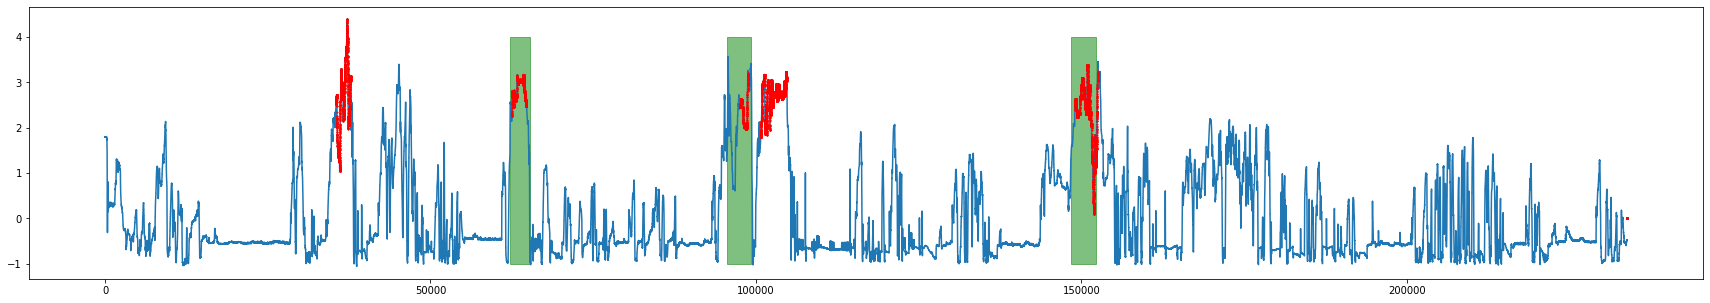

recall : 0.6355140186915887, accuracy : 0.3952798930419113


<Figure size 432x288 with 0 Axes>

In [47]:
####################
#---# Dense AE #---#
####################
print("============== Dense AE ==============")
primitive = load_primitive('keras.Sequential.DenseSeq2Seq',
                           arguments = {'X':X, "y":X, "classification":False, 
                                        "epochs":2000,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "window_size":1000, "batch_size": 16, 
                                        "validation_split":0.2})
primitive.fit()
pred = primitive.produce(X=X_test)
# pred.mean()

primitive = load_primitive('orion.primitives.timeseries_errors.reconstruction_errors')
errors, predictions = primitive.produce(y=X_test, y_hat=pred)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                           arguments = {'anomaly_padding':1})
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("=== error_rangeㅍ===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

TadGAN

============== TadGAN ==============


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/3, [Dx loss: [ 55.797863   18.503263  -39.106705    7.6401296]] [Dz loss: [-229.05824     8.458718 -553.4674     31.595043]] [G loss: [808.87976    31.550457  763.9698      1.3359449]]
Epoch: 2/3, [Dx loss: [252.67796  -34.18668   -9.745718  29.661036]] [Dz loss: [-175.34448      5.7764554 -340.64658     15.952569 ]] [G loss: [651.49384   -65.1284    698.15643     1.8465773]]
Epoch: 3/3, [Dx loss: [3529.699    146.85173 -168.02318  355.08704]] [Dz loss: [-178.08934     7.657335 -555.1234     36.937664]] [G loss: [ 778.10065   -101.59907    863.2375       1.6462172]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


average reconstructed value:nan, critic score:-1147.8681640625


/usr/local/lib/python3.7/dist-packages/orion/primitives/tadgan.py:342: RuntimeWarning: invalid value encountered in true_divide
  z_scores = np.absolute((np.asarray(critics) - critic_mean) / critic_std) + 1
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


=== error_range ===
 [[5.98000000e+02 6.04000000e+02 2.43475462e-01]]


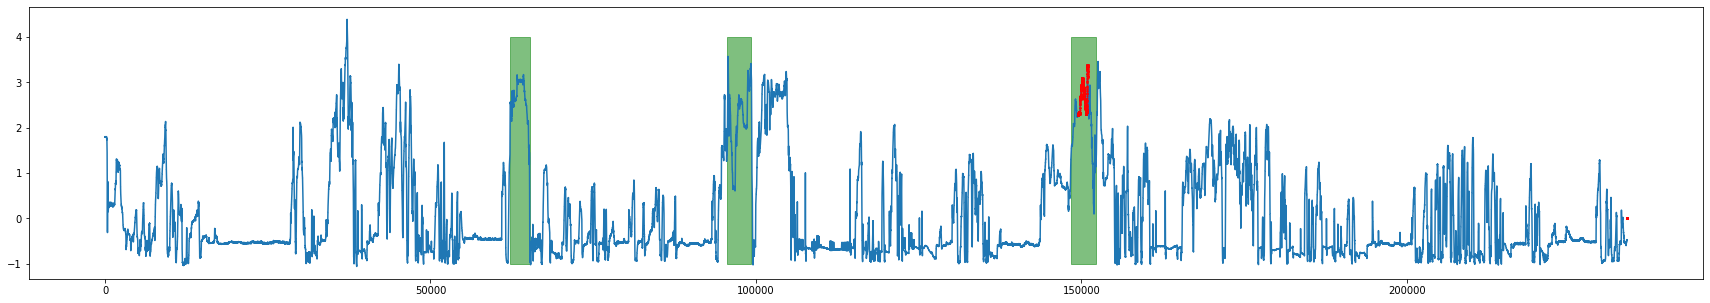

recall : 0.14018691588785046, accuracy : 0.1394959546173161


<Figure size 432x288 with 0 Axes>

In [49]:
####################
#---# TadGAN #---#
####################
from keras.layers import Input, Lambda, Dense
import tensorflow as tf

print("============== TadGAN ==============")
primitive = load_primitive('orion.primitives.tadgan.TadGAN',
                           arguments = {'X':X, "y":X, 
                                        "epochs":3,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "latent_dim" : 100,
                                        # "batch_size": 16, ########
                                        "learning_rate" : 0.01,
                                        "dense_units" : 100
                                        })
primitive.fit()

pred, critic = primitive.produce(X=X_test, y=true_label_sliding)
print(f'average reconstructed value:{y.mean()}, critic score:{critic[0][0]}')

primitive = load_primitive('orion.primitives.tadgan.score_anomalies',
                           arguments = {'error_smooth_window':10,
                                        'critic_smooth_window':10,
                                        'score_window':10,
                                        'comb':'rec'})
index = np.array([[1]])
errors, true_index, true, predictions = primitive.produce(y=X_test, y_hat=pred, critic=critic, index=index)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                           arguments = {'anomaly_padding':1})
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("=== error_range ===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

In [50]:
####################
#---# TadGAN #---#
####################
from keras.layers import Input, Lambda, Dense
import tensorflow as tf

print("============== TadGAN ==============")
primitive = load_primitive('orion.primitives.tadgan.TadGAN',
                           arguments = {'X':X, "y":X, 
                                        "epochs":5,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "latent_dim" : 50,
                                        # "batch_size": 16, ########
                                        "learning_rate" : 0.05,
                                        "dense_units" : 50
                                        })
primitive.fit()

pred, critic = primitive.produce(X=X_test, y=true_label_sliding)
print(f'average reconstructed value:{y.mean()}, critic score:{critic[0][0]}')

primitive = load_primitive('orion.primitives.tadgan.score_anomalies',
                           arguments = {'error_smooth_window':10,
                                        'critic_smooth_window':10,
                                        'score_window':10,
                                        'comb':'rec'})
index = np.array([[1]])
errors, true_index, true, predictions = primitive.produce(y=X_test, y_hat=pred, critic=critic, index=index)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                           arguments = {'anomaly_padding':1})
error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("=== error_range ===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

============== TadGAN ==============


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected

Epoch: 1/5, [Dx loss: [nan nan nan nan]] [Dz loss: [nan nan nan nan]] [G loss: [nan nan nan nan]]
Epoch: 2/5, [Dx loss: [nan nan nan nan]] [Dz loss: [nan nan nan nan]] [G loss: [nan nan nan nan]]
Epoch: 3/5, [Dx loss: [nan nan nan nan]] [Dz loss: [nan nan nan nan]] [G loss: [nan nan nan nan]]
Epoch: 4/5, [Dx loss: [nan nan nan nan]] [Dz loss: [nan nan nan nan]] [G loss: [nan nan nan nan]]
Epoch: 5/5, [Dx loss: [nan nan nan nan]] [Dz loss: [nan nan nan nan]] [G loss: [nan nan nan nan]]
average reconstructed value:nan, critic score:nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


ValueError: ignored

ARIMA

In [ ]:
#################
#---# ARIMA #---#
#################
'''
steps : number of forward steps to predict
p : the number of autoregressive parameters to use
d : the number of differences to use
q : the number of moving average (MA) parameters to use
'''

# primitive = load_primitive('statsmodels.tsa.arima_model.Arima',
#                            arguments = {"X":np.array(train_scale), "steps":1})
# y = primitive.produce(X=np.array(test_scale)) # predicted values
# print(y)

In [ ]:
xx = np.array([1] * 100).reshape(1,-1,1)
yy = xx[:,:,[0]]
primitive2 = load_primitive('orion.primitives.tadgan.TadGAN',
                            arguments = {"X":xx, "y":xx, "epochs":1, "batch_size":2, "iterations_critic":1})
primitive2.fit()
yyy, critic = primitive2.produce(X=xx, y=yy)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1/1, [Dx loss: nan] [Dz loss: nan] [G loss: nan]


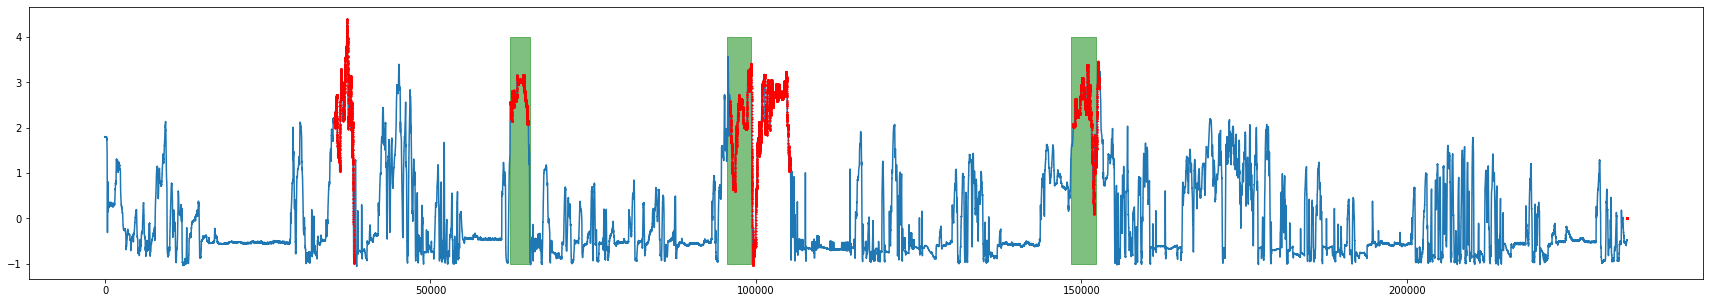

(0.897196261682243, 0.9548637100464922)

<Figure size 432x288 with 0 Axes>

In [ ]:
### TadGAN 모델 입력

print("============== TadGAN ==============")
primitive = load_primitive('orion.primitives.tadgan.TadGAN',
                           arguments = {'X':X, "y":X, 
                                        "epochs":15,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "latent_dim" : 100,
                                        # "batch_size": 16, ########
                                        "learning_rate" : 0.01,
                                        "dense_units" : 100
                                        # "layers_encoder": [
                                        #     # {
                                        #     #   "class": 'keras.layers.InputLayer',
                                        #     #   "parameters" : {
                                        #     #       "input_shape" : (1000,)
                                        #     #   }
                                        #     # },
                                        #     {
                                        #       "class" : "keras.layers.Bidirectional",
                                        #       "parameters" : {
                                        #           "layer" : {
                                        #               "class" : "keras.layers.LSTM",
                                        #               "parameters" : {
                                        #                   "units" : 20,
                                        #                   "return_sequences":True
                                        #               }
                                        #           }
                                        #       }  
                                        #     },
                                        #     {
                                        #       "class" : "keras.layers.Flatten",
                                        #       "parameters" : {}
                                        #     },
                                        #     { "class": 'keras.layers.Dense',
                                        #       "parameters": {
                                        #           'units': 20,
                                        #           'activation': 'relu',
                                        #           # 'input_shape': [1000,],
                                        #       }
                                        #     },
                                        #     { "class" : 'keras.layers.Reshape',
                                        #       "parameters" : {
                                        #           "target_shape" : (1000,-1,1)
                                        #       }
                                        #     }
                                        # ],
                                        # "layers_generator" : [
                                        #     {
                                        #       "class" : "keras.layers.Flatten",
                                        #       "parameters" : {}  
                                        #     },
                                        #     {
                                        #       "class" : "keras.layers.Dense",
                                        #       "parameters" : {
                                        #           "units" : 1000
                                        #       }
                                        #     },
                                        #     {
                                        #       "class" : "keras.layers.Reshape",
                                        #       "parameters" : {
                                        #           "target_shape" : (1000,)
                                        #       }
                                        #     },
                                        #     {
                                        #       "class":"keras.layers.Bidirectional",
                                        #       "parameters" : {
                                        #           "layer" : {
                                        #               "class" : "keras.layers.LSTM",
                                        #               "parameters" : {
                                        #                   "units" : 20,
                                        #                   "return_sequences" : True,
                                        #                   "dropout" : 0.2,
                                        #                   "recurrent_dropout" : 0.2
                                        #               }
                                        #           },
                                        #           "merge_mode" : "concat"
                                        #       }
                                        #     }
                                        # ]
                                                        
                                        # "layers_encoder" : [tf.keras.layers.Dense(20, activation='relu', input_shape=[1000])]
                                        # "layers_encoder" : [tf.keras.Sequential(Dense(20, activation='relu'))] #
                                        })

In [43]:
###################
#---# LSTM AE #---#
###################
print("============== LSTM AE ==============")
primitive = load_primitive('keras.Sequential.LSTMSeq2Seq',
                          arguments = {'X':X, "y":X, "classification":False, 
                                        "epochs":10,
                                        "input_shape":(1000,1),
                                        "target_shape":(1000,1),
                                        "window_size":1000, "batch_size":8, 
                                        "validation_split":0.2})
primitive.fit()
pred = primitive.produce(X=X_test)
# pred.mean()

primitive = load_primitive('orion.primitives.timeseries_errors.reconstruction_errors')
errors, predictions = primitive.produce(y=X_test, y_hat=pred)

primitive = load_primitive('orion.primitives.timeseries_anomalies.find_anomalies',
                          arguments = {'anomaly_padding':1})

error_range = primitive.produce(errors=errors, index=range(len(errors)))
print("=== error_range ===\n", error_range)

prediction = pd.DataFrame(0, index=range(0, len(X_test)), columns={'Fu'})
for i in error_range :
  start = int(i[0])
  end = int(i[1])
  prediction[start:end] = 1

anomaly_value = get_anomaly_time(testdata, prediction['Fu'].values.tolist())
drawing(anomaly_value, pd.DataFrame(testdata))
recall, accuracy = calculate(pd.DataFrame(true_label), pd.DataFrame(anomaly_value))
print(f'recall : {recall}, accuracy : {accuracy}')

============== LSTM AE ==============
Train on 1957 samples, validate on 490 samples
Epoch 1/10
1957/1957 [==============================] - 195s 99ms/step - loss: 0.7800 - mse: 0.7800 - val_loss: 0.5407 - val_mse: 0.5407
Epoch 2/10
1957/1957 [==============================] - 186s 95ms/step - loss: 0.7696 - mse: 0.7696 - val_loss: 0.5283 - val_mse: 0.5283
Epoch 3/10
1957/1957 [==============================] - 186s 95ms/step - loss: 0.7663 - mse: 0.7663 - val_loss: 0.5164 - val_mse: 0.5164
Epoch 4/10
1957/1957 [==============================] - 187s 96ms/step - loss: 0.7679 - mse: 0.7679 - val_loss: 0.5626 - val_mse: 0.5626
Epoch 5/10
1957/1957 [==============================] - 191s 97ms/step - loss: 0.7661 - mse: 0.7661 - val_loss: 0.5751 - val_mse: 0.5751
Epoch 6/10
1957/1957 [==============================] - 186s 95ms/step - loss: 0.7670 - mse: 0.7670 - val_loss: 0.5601 - val_mse: 0.5601
Epoch 7/10
1016/1957 [==============>...............] - ETA: 1:23 - loss: 0.7934 - mse: 0.793

KeyboardInterrupt: ignored